In [1]:
import pandas as pd 
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/un-general-debates/un-general-debates.csv


In [2]:
df = pd.read_csv('/kaggle/input/un-general-debates/un-general-debates.csv')
df.head()

,session,year,country,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   session  7507 non-null   int64 
 1   year     7507 non-null   int64 
 2   country  7507 non-null   object
 3   text     7507 non-null   object
dtypes: int64(2), object(2)
memory usage: 234.7+ KB


## Getting an Overview of the Data with Pandas

### Calculating Summary Statistics for Columns

In [4]:
df['length'] = df['text'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
session,7507.0,49.610763,12.892155,25.0,39.0,51.0,61.0,70.0
year,7507.0,1994.610763,12.892155,1970.0,1984.0,1996.0,2006.0,2015.0
length,7507.0,17967.281604,7860.038463,2362.0,12077.0,16424.0,22479.5,72041.0


In [5]:
df[['country']].describe(include='O').T

,count,unique,top,freq
country,7507,199,IRN,46


### Plotting Value Distributions

<Axes: >

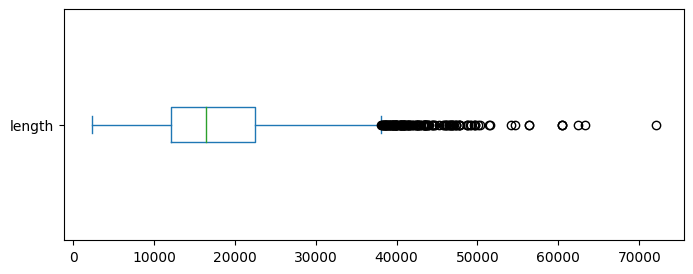

In [6]:
df['length'].plot(kind='box', vert=False, figsize=(8, 3))

<Axes: ylabel='Frequency'>

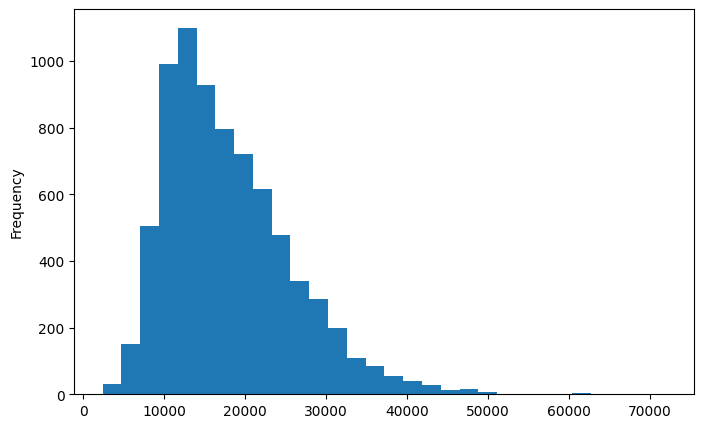

In [7]:
df['length'].plot(kind='hist', bins=30, figsize=(8,5))

/tmp/ipykernel_20/1332856417.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['length'], bins=30, kde=True)


<Axes: xlabel='length', ylabel='Density'>

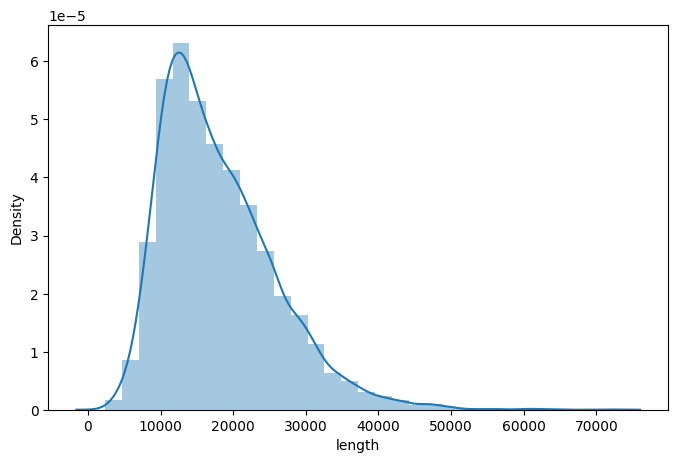

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.distplot(df['length'], bins=30, kde=True)

### Comparing Value Distributions across Categories

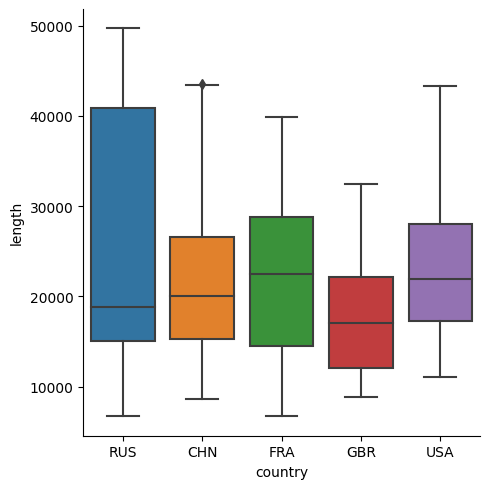

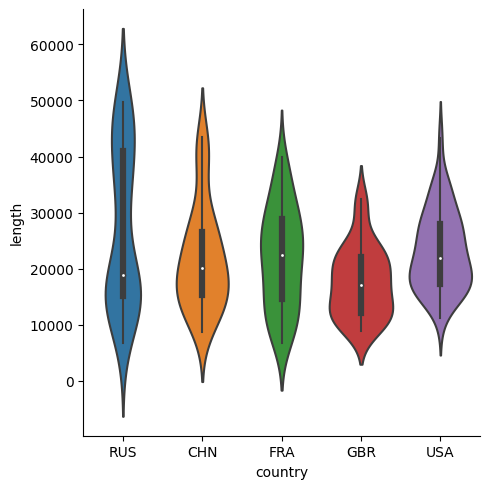

In [9]:
where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])

sns.catplot(data=df[where], x="country", y="length", kind='box')
sns.catplot(data=df[where], x="country", y="length", kind='violin')

### Visualizing Developments over Time

<Axes: title={'center': 'Number of Countries'}, xlabel='year'>

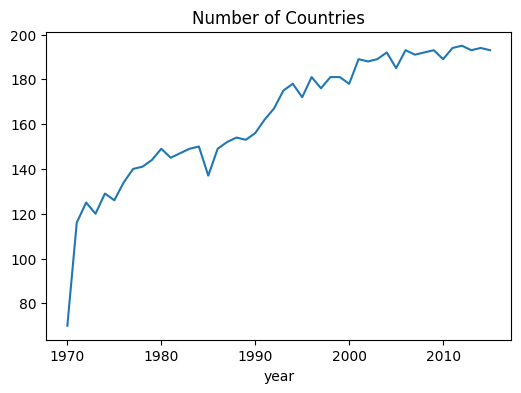

In [10]:
df.groupby('year').size().plot(title="Number of Countries", figsize=(6,4))

<Axes: title={'center': 'Avg. Speech Length'}, xlabel='year'>

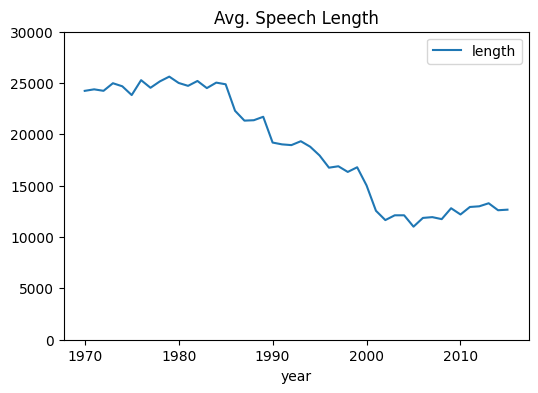

In [11]:
df.groupby('year').agg({'length': 'mean'}) \
  .plot(title="Avg. Speech Length", ylim=(0,30000), figsize=(6,4))

## Building a Simple Text Preprocessing Pipeline

### Tokenization with Regular Expressions

In [12]:
import regex as re


def tokenize(text: str) -> list:
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [13]:
text = "I hope everyone gets a better start to 2024!"
tokens = tokenize(text)
print("|".join(tokens))

I|hope|everyone|gets|a|better|start|to


## Treating Stop Words

In [14]:
import nltk


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
stopwords = set(nltk.corpus.stopwords.words('english'))   # convert to set for fast performance

In [16]:
def remove_stop(tokens: list) -> list:
    return [t for t in tokens if t.lower() not in stopwords]

In [17]:
# update the list of stop words
include_stopwords = {'dear', 'regards', 'must', 'would', 'also'}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

## Processing a Pipeline with one Line of Code

In [18]:
def preprocessing(text: str, pipeline: list = None) -> list:
    tokens = text
    if pipeline is None:
        pipeline = [str.lower, tokenize, remove_stop]
        
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [19]:
from tqdm.notebook import tqdm


tqdm.pandas()

df['tokens'] = df['text'].progress_apply(preprocessing)

  0%|          | 0/7507 [00:00<?, ?it/s]

In [20]:
df['num_tokens'] = df['tokens'].progress_map(len)

  0%|          | 0/7507 [00:00<?, ?it/s]

## Word Frequency Analysis

### Counting Words with a Counter

In [21]:
from collections import Counter

counter = Counter()
# Use update method to iterate over text/tokens
_ = df['tokens'].map(counter.update)

In [22]:
counter.most_common(5)

[('nations', 124508),
 ('united', 120763),
 ('international', 117223),
 ('world', 89421),
 ('countries', 85734)]

In [23]:
from typing import Callable


def count_words(ds: pd.Series, preprocess: Callable = None, min_freq: int = 2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    ds.progress_map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [24]:
freq_df = count_words(df['tokens'])
freq_df.head(5)

  0%|          | 0/7507 [00:00<?, ?it/s]

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


In [25]:
# top words with 10+ characters
count_words(df['text'], preprocess=lambda text: re.findall(r"\w{10,}", text)).head(5)

  0%|          | 0/7507 [00:00<?, ?it/s]

,freq
token,
international,106974
development,51334
Government,35528
Organization,33763
developing,25177


## Creating a Frequency Diagram

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

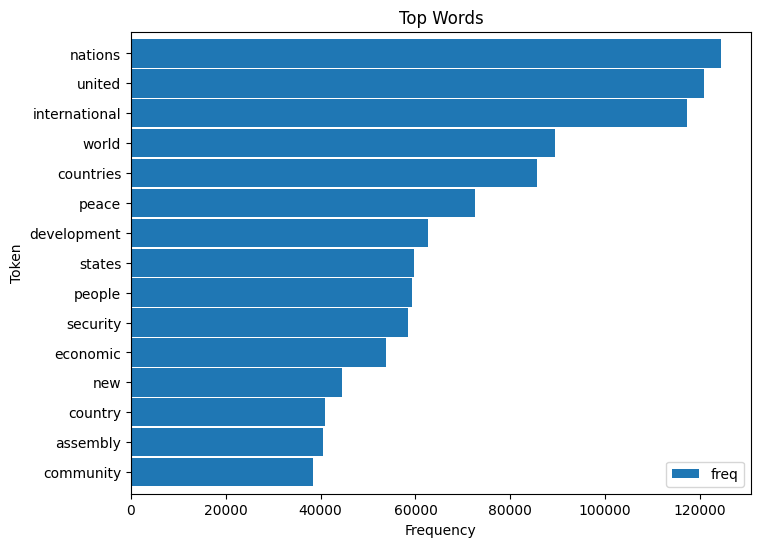

In [26]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,6))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

## Creating Word Clouds

In [27]:
from wordcloud import WordCloud

text = df.query("year==2015 and country=='USA'")['text'].values[0]

(-0.5, 799.5, 399.5, -0.5)

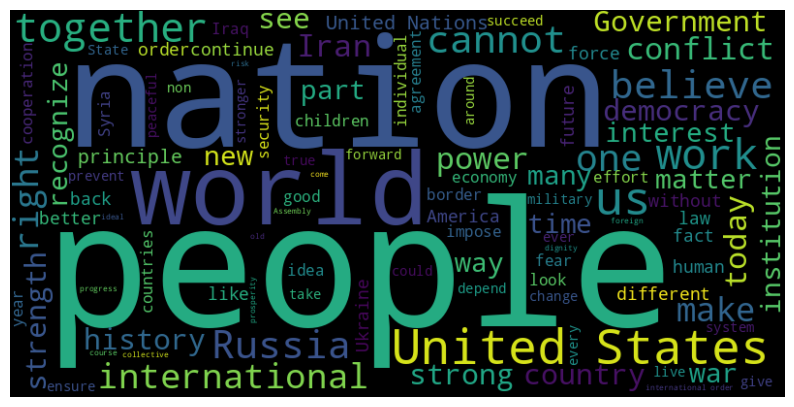

In [28]:
plt.figure(figsize=(10, 8))
wc = WordCloud(max_words=100, stopwords=stopwords, scale=2)
wc.generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [29]:
def wordcloud(word_freq: pd.DataFrame | pd.Series, title: str = None, max_words: int = 200, stopwords: set | list = None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() if token not in stopwords}
        
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

  0%|          | 0/193 [00:00<?, ?it/s]

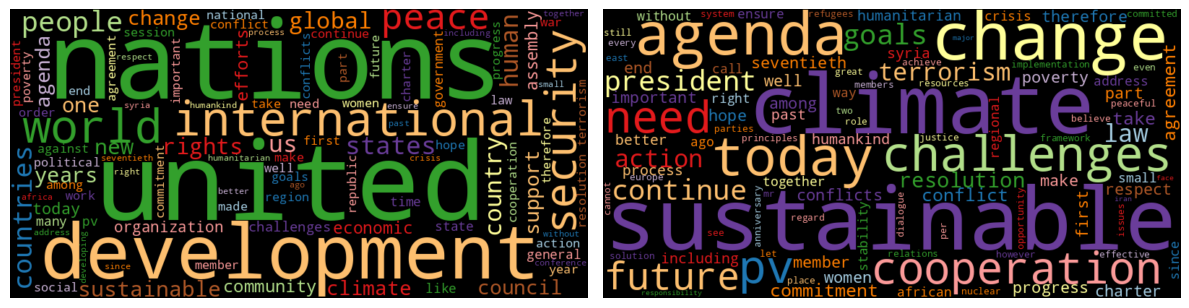

In [30]:
freq_2015_df = count_words(df.loc[df['year'] == 2015, 'tokens'])

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
wordcloud(freq_2015_df['freq'], max_words=100)

plt.subplot(1,2,2)
wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_df.head(50).index)

plt.tight_layout()

See the difference between 1 & 2? that's because we filter words that has high count but don't really contribute to topic. In this case, it would be words like world, nations, united. These can also be considered as stopwords, at least in the context of our data.

## Ranking with TF-IDF

In [31]:
import numpy as np


def compute_idf(ds: pd.Series, preprocess: Callable = None, min_df: int = 2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    ds.progress_map(update)

    # create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(ds) / idf_df['df']) + 0.1
    idf_df.index.name = 'token'
    return idf_df

In [32]:
idf_df = compute_idf(df['tokens'])

  0%|          | 0/7507 [00:00<?, ?it/s]

/tmp/ipykernel_20/2722674863.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(ds) / idf_df['df']) + 0.1


In [33]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

In [34]:
freq_1970 = count_words(df.loc[df['year'] == 1970, 'tokens'])
freq_2015 = count_words(df.loc[df['year'] == 2015, 'tokens'])

freq_1970['tfidf'] = freq_1970['freq'] * idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq'] * idf_df['idf']

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

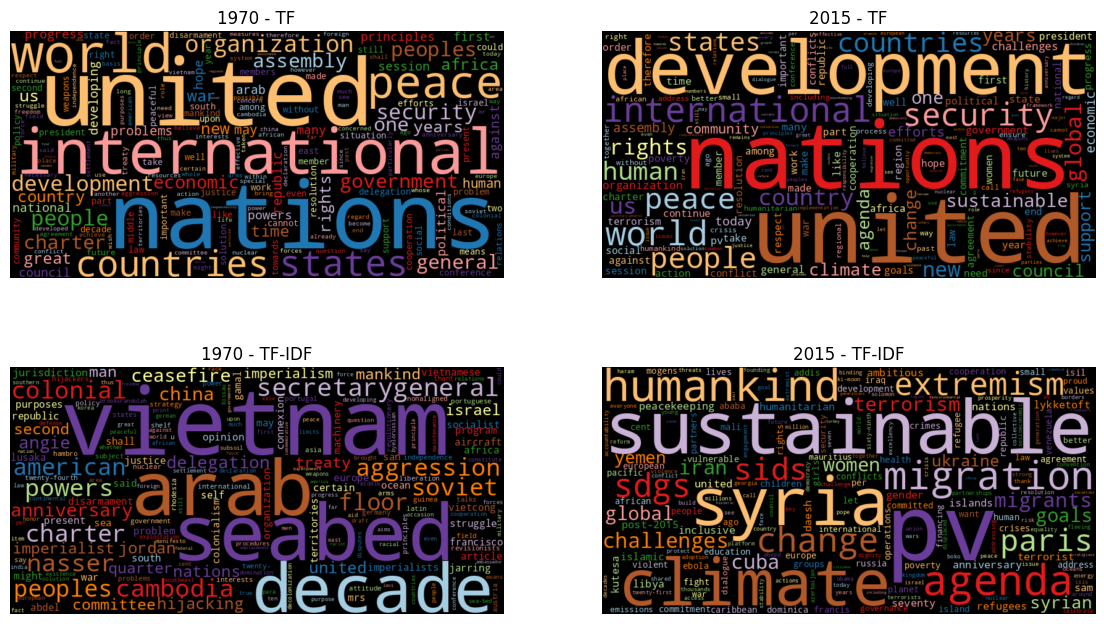

In [35]:
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
wordcloud(freq_1970['freq'], title='1970 - TF', stopwords=['twenty-fifth', 'twenty-five'])

plt.subplot(2,2,2)
wordcloud(freq_2015['freq'], title='2015 - TF', stopwords=['seventieth'])

plt.subplot(2,2,3)
wordcloud(freq_1970['tfidf'], title='1970 - TF-IDF', stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])

plt.subplot(2,2,4)
wordcloud(freq_2015['tfidf'], title='2015 - TF-IDF', stopwords=['seventieth'])

We see a clear different between common words without tf-idf vs with tf-idf. 

## Finding a Keyword in Context (KWIC)

In [36]:
! pip install textacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.2 MB/s eta 0:00:00
  Obtaining dependency information for floret~=0.10.0 from https://files.pythonhosted.org/packages/16/ee/388a5c76c9292f4bef85d7ef895005bb39a0899f8004e9daceb57b2bb0c9/floret-0.10.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for jellyfish>=0.8.0 from https://files.pythonhosted.org/packages/26/87/8d31224804af9dfa7b34657e083b67b24b322c41dd9464b52218c1a33890/jellyfish-1.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.4 MB/s eta 0:00:00


In [37]:
from textacy.extract.kwic import keyword_in_context

In [38]:
import random


def kwic(doc_series: pd.DataFrame, keyword: str, window=35, print_samples=5):
    
    kwic_list = []

    def add_kwic(text):
        kwic_list.extend(keyword_in_context(text, keyword, ignore_case=True, window_width=window))

    doc_series.progress_map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} contexts for '{keyword}':")
        
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

2015 tf-idf showed words like sgds, sids which we don't know the meaning. Let's find those words in the context to understand them better if possible.

In [39]:
kwic(df[df['year'] == 2015]['text'], 'sdgs', print_samples=5)

  0%|          | 0/193 [00:00<?, ?it/s]

5 random samples out of 73 contexts for 'sdgs':
 of Sustainable Development Goals (  SDGs  ). Given the ambition reflected in 
its Sustainable Development Goals (  SDGs  ) (resolution 70/1), which can be c
 and reviewing our progress on the   SDGs   throughout the next 15 years is vi
 assistance-delivery to target the   SDGs  , then my nation too can climb the 
the islands have a warning for our   SDGs  . Without a healthy ocean it would 


We observe that we have sgds which stands for Sustainable Development Goals in our dataset. It's important to investigate

In [40]:
kwic(df[df['year'] == 2015]['text'], 'sids', print_samples=5)

  0%|          | 0/193 [00:00<?, ?it/s]

5 random samples out of 84 contexts for 'sids':
or small island developing States (  SIDS  ), my statement in essence is devot
ng small island developing States (  SIDS  ). To the President of the General 
s not far from reality to say that   SIDS   and LDCs, such as Solomon Islands,
of the international community for   SIDS  . A key part of our work will be to
circumstances and vulnerability of   SIDS  , particularly those in the Pacific


SIDS = Small Islands Developing States

## Analyzing N-Grams

In [41]:
def ngrams(tokens: list, n: int = 2, sep: str = ' ', stopwords: set = None) -> list:
    return [
        sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)]) 
        if len([t for t in ngram if t in stopwords]) == 0
    ]

In [42]:
# Print for an example first
print("Bigrams:", "|".join(ngrams(tokens, 2, stopwords=stopwords)))
print("Trigrams:", "|".join(ngrams(tokens, 3, stopwords=stopwords)))

Bigrams: I hope|hope everyone|everyone gets|better start
Trigrams: I hope everyone|hope everyone gets


In [43]:
df['bigrams'] = (df['text'].progress_apply(preprocessing, pipeline=[str.lower, tokenize])
                           .progress_apply(ngrams, n=2, stopwords=stopwords))

count_words(df['bigrams']).head(5)

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

,freq
token,
united nations,103236
international community,27786
general assembly,27096
security council,20961
human rights,19856


In [44]:
idf_df = pd.concat([compute_idf(df['tokens']), compute_idf(df['bigrams'], min_df=10)])

freq_df = count_words(df.loc[df['year'] == 2015, 'bigrams'])
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

  0%|          | 0/7507 [00:00<?, ?it/s]

/tmp/ipykernel_20/2722674863.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(ds) / idf_df['df']) + 0.1


  0%|          | 0/7507 [00:00<?, ?it/s]

/tmp/ipykernel_20/2722674863.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(ds) / idf_df['df']) + 0.1


  0%|          | 0/193 [00:00<?, ?it/s]

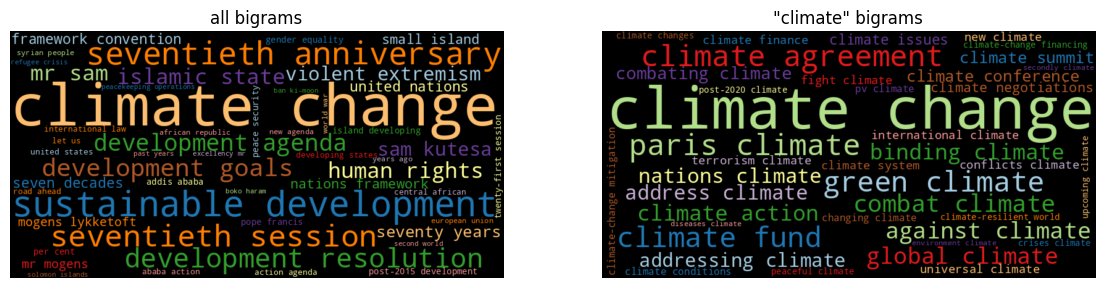

In [45]:
plt.figure(figsize=(14,8))

plt.subplot(1,2,1)
wordcloud(freq_df['tfidf'], title='all bigrams', max_words=50)

plt.subplot(1,2,2)
where = freq_df.index.str.contains('climate')
wordcloud(freq_df[where]['freq'], title='"climate" bigrams', max_words=50)

## Comparing Frequencies across Time-Intervals and Categories

### Creating Frequency Timelines

In [46]:
def count_keywords(tokens: list, keywords: list) -> list: 
    counter = Counter([t for t in tokens if t in keywords])
    return [counter.get(k, 0) for k in keywords]

In [47]:
keywords = ['nuclear', 'terrorism', 'climate', 'freedom']
tokens = ['nuclear', 'climate', 'climate', 'freedom', 'climate', 'freedom']

print(count_keywords(tokens, keywords))

[1, 0, 3, 2]


In [48]:
def count_keywords_by(df: pd.DataFrame, by: str, keywords: list, column: str = 'tokens'):
    
    df = df.reset_index(drop=True) # to be safe
    freq_matrix = df[column].progress_apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by] # copy the grouping column(s)
    
    return freq_df.groupby(by=by).sum().sort_values(by)

In [49]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)

  0%|          | 0/7507 [00:00<?, ?it/s]

<Axes: xlabel='year'>

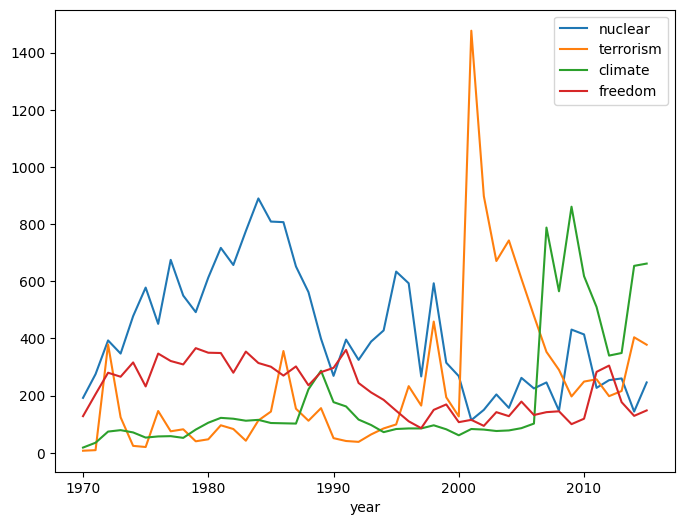

In [50]:
freq_df.plot(kind='line', figsize=(8, 6))

In [51]:
# analyzing mentions of 'climate' before 1980
kwic(df.query('year < 1980')['text'], 'climate', window=35, print_samples=5)

  0%|          | 0/1245 [00:00<?, ?it/s]

5 random samples out of 581 contexts for 'climate':
ability in inter-State relations a   climate   that favours the development among
s calculated to create a favorable   climate   for convening the conference on se
f improvement of the international   climate  , certain groups are intensifying t
 136. Austria's desire to create a   climate   of mutual confidence in its part o
 the whole international political   climate  . 50. We can judge the state and th


As we see, it's not relate to climate change so context was different which makes us think about the interpretation of our results.

### Creating Frequency Heat Maps

  0%|          | 0/7507 [00:00<?, ?it/s]

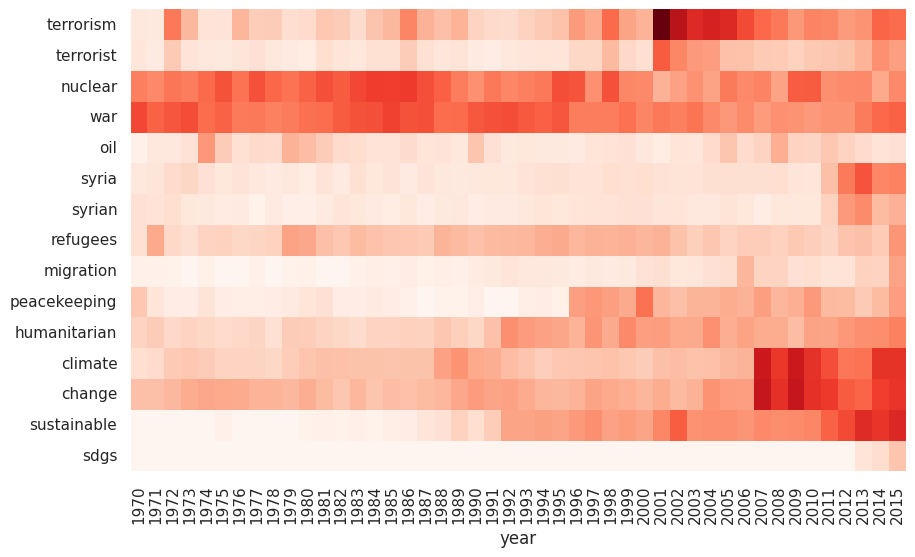

In [52]:
import seaborn as sns

keywords = ['terrorism', 'terrorist', 'nuclear', 'war', 'oil',
            'syria', 'syrian', 'refugees', 'migration', 'peacekeeping', 
            'humanitarian', 'climate', 'change', 'sustainable', 'sdgs']  

freq_df = count_keywords_by(df, by='year', keywords=keywords)

# compute relative frequencies based on total number of tokens per year
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)

# apply square root as sublinear filter for better contrast
freq_df = freq_df.apply(np.sqrt)

plt.figure(figsize=(10, 6))

sns.set(font_scale=1)
sns.heatmap(data=freq_df.T, xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")
sns.set(font_scale=1)

Note that we used a sublinear scaling as frenquency values differ greatly so it might be hard to see any change for less frequent tokens